# Option hedging with a Long-Short-Term-Memory Recurrent Neural Network Part I

By Matthias Groncki (June 2018)

In this notebook we are building a Long-Short-Term Memory (LSTM) RNN in TensorFlow to learn a optimal hedging strategy for a Call Options from the market prices of the underlying asset. This approach is data-driven and 'model free' as it doesnt make any assumptions of the underlying stochastic process. The model can easily extended to incoperate transaction costs and trading limits. 

I follow the idea presented in the paper 'Deep Hedging' (https://arxiv.org/abs/1802.03042) by Hans Bühler, Lukas Gonon, Josef Teichmann, Ben Wood and the work of Hutchinson et. al. 'A Nonparametric approach to pricing and hedging derivative securities via learning network' (http://alo.mit.edu/wp-content/uploads/2015/06/A-Nonparametric-Approach-to-Pricing-and-Hedging-Derivative-Securities-via-Learning-Networks.pdf).

We will train a RNN network to learn a optimal hedging strategy given the individual risk aversion of the trader (we will minimize the conditional Value at Risk or Expected Shortfall of the hedging strategy) and derive the option price from this hedging strategy. 

In this part we implement a basic 3 layer LSTM network in TensorFlow and we train the model on a Black Scholes process with a drift of zero (risk free interest is zero) and a volatility of 20%. The training option matures in one month and has a moneyness of one ($S/K=1)$.

For simplicty we use synthetic market prices of the underlying gernerated by a Black Scholes Process. This can easily adopted to more spohisticated models (see the reference paper for a Heston Model example) or even use real market data.

We will compare the effectivness of the hedging strategy and compare it to the delta hedging strategy using the Black Scholes Delta. We will see the influence of the risk aversion of the trader and we will see how well the network can generalize the hedging strategy if we change the moneyness of the option, the drift (should have no effect in theory) and the volatility of the underlying process.

In the comming parts we will try improve the network by changing the network architecture (e.g. simple MLP or Convolutional Networks) or using other and more features and try some approach to generate training data from market data or try transfer learning methods (since we dont have millions of training paths of one underlying) and include transaction costs.

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import scipy.stats as stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

### Black Scholes price and delta

First some helper function to calculate the analytical Black Scholes price and delta for a Call option.

In [2]:
def BS_d1(S, dt, r, sigma, K):
    return (np.log(S/K) + (r+sigma**2/2)*dt) / (sigma*np.sqrt(dt))

def BlackScholes_price(S, T, r, sigma, K, t=0):
    dt = T-t
    Phi = stats.norm(loc=0, scale=1).cdf
    d1 = BS_d1(S, dt, r, sigma, K)
    d2 = d1 - sigma*np.sqrt(dt)
    return S*Phi(d1) - K*np.exp(-r*dt)*Phi(d2)

def BS_delta(S, T, r, sigma, K, t=0):
    dt = T-t
    d1 = BS_d1(S, dt, r, sigma, K)
    Phi = stats.norm(loc=0, scale=1).cdf
    return Phi(d1)

### Simulation of the underlying price

Helper function to generate training and test sets

In [3]:
def monte_carlo_paths(S_0, time_to_expiry, sigma, drift, seed, n_sims, n_timesteps):
    """
    Create random paths of a underlying following a browian geometric motion
    
    input:
    
    S_0 = Spot at t_0
    time_to_experiy = end of the timeseries (last observed time)
    sigma = the volatiltiy (sigma in the geometric brownian motion)
    drift = drift of the process
    n_sims = number of paths to generate
    n_timesteps = numbers of aquidistant time steps 
    
    return:
    
    a (n_timesteps x n_sims x 1) matrix
    """
    if seed > 0:
            np.random.seed(seed)
    stdnorm_random_variates = np.random.randn(n_sims, n_timesteps)
    S = S_0
    dt = time_to_expiry / stdnorm_random_variates.shape[1]
    r = drift
    # See Advanced Monte Carlo methods for barrier and related exotic options by Emmanuel Gobet
    S_T = S * np.cumprod(np.exp((r-sigma**2/2)*dt+sigma*np.sqrt(dt)*stdnorm_random_variates), axis=1)
    return np.reshape(np.transpose(np.c_[np.ones(n_sims)*S_0, S_T]), (n_timesteps+1, n_sims, 1))

In [4]:
S_0 = 100
K = 100
r = 0
vol = 0.2
T = 1/12
timesteps = 30

We will test our network with three test sets:
    
- First: We test the network with an out of sample test set from the same stochastic process `paths_test_1`

- Second: We assume we trained our model to hedge a stock with same volatility but different drift.

- Third: We test the hedge portfolio given on a sample generate with from a geometric brownian motion with shifed volatility

In [5]:
# Train the model on the path of the risk neutral measure
paths_train = monte_carlo_paths(S_0, T, vol, r, 42, 500000, timesteps)

## Testing a hedging strategy

If we could rebalance our replication portfolio in continous time, the PnL of the replication portfolio using the Black Scholes Delta would be zero.

But since we can trade only at discrite times there will be an error. The more often we balance our replication portfolio the smaller the hedge error will be. 

We will use the function `test_hedging_strategy()` to calculates the PnL and the CVaR of a hedging strategy given  the amount of underlying to hold at each time on each path `deltas`, the realized path of the underlying `paths`, the strike `K`, the level of the CVaR `alpha`.

In [6]:
def test_hedging_strategy(deltas, paths, K, price, alpha, output=True):
    S_returns = paths[1:,:,0]-paths[:-1,:,0]
    hedge_pnl = np.sum(deltas * S_returns, axis=0)
    option_payoff = np.maximum(paths[-1,:,0] - K, 0)
    replication_portfolio_pnls = -option_payoff + hedge_pnl + price
    mean_pnl = np.mean(replication_portfolio_pnls)
    cvar_pnl = -np.mean(np.sort(replication_portfolio_pnls)[:int((1-alpha)*replication_portfolio_pnls.shape[0])])
    if output:
        plt.hist(replication_portfolio_pnls)
        print('BS price at t0:', price)
        print('Mean Hedging PnL:', mean_pnl)
        print('CVaR Hedging PnL:', cvar_pnl)
    return (mean_pnl, cvar_pnl, hedge_pnl, replication_portfolio_pnls, deltas)

def plot_deltas(paths, deltas_bs, deltas_rnn, times=[0, 1, 5, 10, 15, 29]):
    fig = plt.figure(figsize=(10,6))
    for i, t in enumerate(times):
        plt.subplot(2,3,i+1)
        xs =  paths[t,:,0]
        ys_bs = deltas_bs[t,:]
        ys_rnn = deltas_rnn[t,:]
        df = pd.DataFrame([xs, ys_bs, ys_rnn]).T
        #df = df.groupby(0, as_index=False).agg({1:np.mean,
        #                                          2: np.mean})
        plt.plot(df[0], df[1], df[0], df[2], linestyle='', marker='x' )
        plt.legend(['BS delta', 'RNN Delta'])
        plt.title('Delta at Time %i' % t)
        plt.xlabel('Spot')
        plt.ylabel('$\Delta$')
    plt.tight_layout()
    
def plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn):
    fig = plt.figure(figsize=(10,6))
    sns.boxplot(x=['Black-Scholes', 'RNN-LSTM-v1 '], y=[portfolio_pnl_bs, portfolio_pnl_rnn])
    plt.title('Compare PnL Replication Strategy')
    plt.ylabel('PnL')

The function `black_scholes_hedge_strategy` calculates the Black Scholes delta hedge strategy on simulated paths of the underlying and test it.

In [7]:
def black_scholes_hedge_strategy(S_0, K, r, vol, T, paths, alpha, output):
    bs_price = BlackScholes_price(S_0, T, r, vol, K, 0)
    times = np.zeros(paths.shape[0])
    times[1:] = T / (paths.shape[0]-1)
    times = np.cumsum(times)    
    bs_deltas = np.zeros((paths.shape[0]-1, paths.shape[1]))
    for i in range(paths.shape[0]-1):
        t = times[i]
        bs_deltas[i,:] = BS_delta(paths[i,:,0], T, r, vol, K, t)
    return test_hedging_strategy(bs_deltas, paths, K, bs_price, alpha, output)

In [8]:
no_rehedges_mean_error = {}
replication_portfolios  = {}
for timestep in np.arange(1,61):
    t_paths = monte_carlo_paths(S_0, T, vol, r, 2101, 10000, timestep)
    no_rehedges_mean_error[timestep], _, _, replication_portfolios[timestep],_ = black_scholes_hedge_strategy(S_0, K, r, vol, T, t_paths, 0.99, False)
    

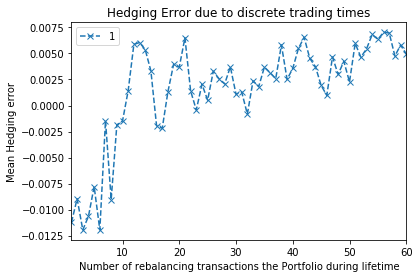

In [9]:
pd.DataFrame(list(no_rehedges_mean_error.items())).plot(0, 1, style='--x')
plt.xlabel('Number of rebalancing transactions the Portfolio during lifetime')
plt.ylabel('Mean Hedging error')
plt.title('Hedging Error due to discrete trading times')
plt.savefig('hedging_error_bs1.png')

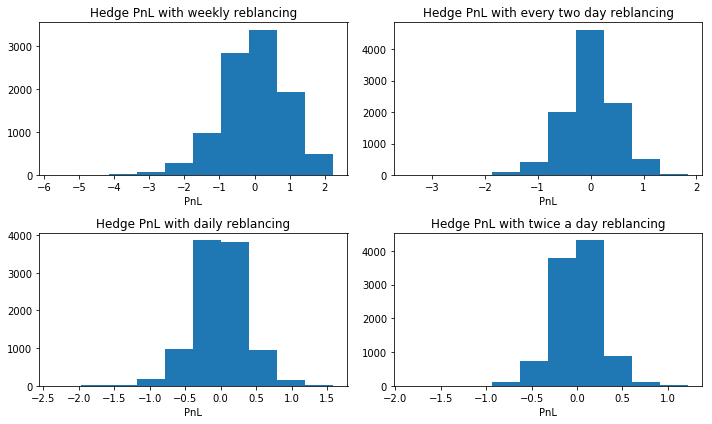

In [10]:
plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
_ = plt.hist(replication_portfolios[4])
_ = plt.title('Hedge PnL with weekly reblancing')
_ = plt.xlabel('PnL')
plt.subplot(2,2,2)
_ = plt.hist(replication_portfolios[15])
_ = plt.title('Hedge PnL with every two day reblancing')
_ = plt.xlabel('PnL')
plt.subplot(2,2,3)
_ = plt.hist(replication_portfolios[30])
_ = plt.title('Hedge PnL with daily reblancing')
_ = plt.xlabel('PnL')
plt.subplot(2,2,4)
_ = plt.hist(replication_portfolios[60])
_ = plt.title('Hedge PnL with twice a day reblancing')
_ = plt.xlabel('PnL')
plt.tight_layout()
plt.savefig('hedging_error2.png')

### RNN-LSTM Network

We wrap out network in the class RnnModel. In the constructor we build the computational graph in TensorFlow using the `LSTMCell` and stack them with the `tf.MultiRNNCell`. Our loss is the $\alpha$-CVaR. We sort the negative realized PnLs of the trading strategy and calculate the mean of the $1-\alpha$ top losses.

The class provide a function to train the model in batches (applying a stochastic gradient descent optimizer) and a method to make prediction. 

We train the model for 100 epochs and save a model checkpoint every 10 epochs on the hard disk.

In [11]:
class RnnModel(object):
    def __init__(self, time_steps, batch_size, features, nodes = [62,46,46,1], name='model'):
        tf.reset_default_graph()
        self.batch_size = batch_size
        self.S_t_input = tf.placeholder(tf.float32, [time_steps, batch_size, features])
        self.K = tf.placeholder(tf.float32, batch_size)
        self.alpha = tf.placeholder(tf.float32)

        S_T = self.S_t_input[-1,:,0]
        dS = self.S_t_input[1:, :, 0] - self.S_t_input[0:-1, :, 0]
        #dS = tf.reshape(dS, (time_steps, batch_size))

        #Prepare S_t for the use in the RNN remove the last time step (at T the portfolio is zero)
        S_t = tf.unstack(self.S_t_input[:-1, :,:], axis=0)

        # Build the lstm
        lstm = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(n) for n in nodes])


        self.strategy, state = tf.nn.static_rnn(lstm, S_t, initial_state=lstm.zero_state(batch_size, tf.float32), dtype=tf.float32)

        self.strategy = tf.reshape(self.strategy, (time_steps-1, batch_size))
        self.option = tf.maximum(S_T-self.K, 0)

        self.Hedging_PnL = - self.option + tf.reduce_sum(dS*self.strategy, axis=0)
        self.Hedging_PnL_Paths = - self.option + dS*self.strategy
        # Calculate the CVaR for a given confidence level alpha
        # Take the 1-alpha largest losses (top 1-alpha negative PnLs) and calculate the mean
        CVaR, idx = tf.nn.top_k(-self.Hedging_PnL, tf.cast((1-self.alpha)*batch_size, tf.int32))
        CVaR = tf.reduce_mean(CVaR)
        self.train = tf.train.AdamOptimizer().minimize(CVaR)
        self.saver = tf.train.Saver()
        self.modelname = name
        
    def _execute_graph_batchwise(self, paths, strikes, riskaversion, sess, epochs=1, train_flag=False):
        sample_size = paths.shape[1]
        batch_size=self.batch_size
        idx = np.arange(sample_size)
        start = dt.datetime.now()
        for epoch in range(epochs):
            # Save the hedging Pnl for each batch      
            pnls = []
            strategies = []
            if train_flag:
                np.random.shuffle(idx)
            for i in range(int(sample_size/batch_size)):
                indices = idx[i*batch_size : (i+1)*batch_size]
                batch = paths[:,indices,:]
                if train_flag:
                    _, pnl, strategy = sess.run([self.train, self.Hedging_PnL, self.strategy], {self.S_t_input: batch,
                                                                                          self.K : strikes[indices],
                                                                                          self.alpha: riskaversion})
                else:
                    pnl, strategy = sess.run([self.Hedging_PnL, self.strategy], {self.S_t_input: batch,
                                                                                self.K : strikes[indices],
                                                                                self.alpha: riskaversion})
                pnls.append(pnl)
                strategies.append(strategy)
            #Calculate the option prive given the risk aversion level alpha
            CVaR = np.mean(-np.sort(np.concatenate(pnls))[:int((1-riskaversion)*sample_size)])
            if train_flag:
                if epoch % 10 == 0:
                    print('Time elapsed:', dt.datetime.now()-start)
                    print('Epoch', epoch, 'CVaR', CVaR)
                    self.saver.save(sess, r"./models/%s/model.ckpt" % self.modelname)
        self.saver.save(sess, r"./models/%s/model.ckpt" % self.modelname)
        return CVaR, np.concatenate(pnls), np.concatenate(strategies,axis=1)
    
    def training(self, paths, strikes, riskaversion, epochs, session, init=True):
        if init:
            sess.run(tf.global_variables_initializer())
        self._execute_graph_batchwise(paths, strikes, riskaversion, session, epochs, train_flag=True)
        
    def predict(self, paths, strikes, riskaversion, session):
        return self._execute_graph_batchwise(paths, strikes, riskaversion,session, 1, train_flag=False)

    def restore(self, session, checkpoint):
        self.saver.restore(session, checkpoint)

In [41]:
batch = paths_train[:,[1,2,3],:]

In [43]:
batch

array([[[100.        ],
        [100.        ],
        [100.        ]],

       [[ 99.36223241],
        [ 99.49065205],
        [100.09682001]],

       [[101.31568706],
        [ 99.2906212 ],
        [101.11846768]],

       [[101.29564588],
        [ 98.1339878 ],
        [100.36734766]],

       [[100.16698268],
        [ 96.89898914],
        [100.01573404]],

       [[101.03363178],
        [ 97.72704187],
        [ 99.59767049]],

       [[ 99.73623704],
        [ 99.12867712],
        [ 98.06753932]],

       [[ 99.95050683],
        [ 99.0479589 ],
        [ 98.3686587 ]],

       [[ 97.90159479],
        [100.09570479],
        [ 98.634239  ]],

       [[ 96.53512904],
        [100.47241367],
        [ 98.63407576]],

       [[ 96.73028298],
        [ 99.78595921],
        [ 98.38501214]],

       [[ 97.48076567],
        [100.16124855],
        [ 96.92268547]],

       [[ 97.6515869 ],
        [101.79267494],
        [ 96.48852188]],

       [[ 97.52719992],
        [101.7

In [46]:
batch[1:, :, 0] - batch[0:-1, :, 0]

array([[-6.37767589e-01, -5.09347953e-01,  9.68200067e-02],
       [ 1.95345465e+00, -2.00030845e-01,  1.02164767e+00],
       [-2.00411780e-02, -1.15663340e+00, -7.51120019e-01],
       [-1.12866320e+00, -1.23499866e+00, -3.51613620e-01],
       [ 8.66649095e-01,  8.28052728e-01, -4.18063555e-01],
       [-1.29739473e+00,  1.40163525e+00, -1.53013117e+00],
       [ 2.14269789e-01, -8.07182198e-02,  3.01119389e-01],
       [-2.04891204e+00,  1.04774589e+00,  2.65580295e-01],
       [-1.36646575e+00,  3.76708889e-01, -1.63238531e-04],
       [ 1.95153942e-01, -6.86454462e-01, -2.49063622e-01],
       [ 7.50482686e-01,  3.75289332e-01, -1.46232667e+00],
       [ 1.70821231e-01,  1.63142640e+00, -4.34163583e-01],
       [-1.24386984e-01, -4.40865450e-02, -3.53279654e-01],
       [-3.14452861e-01,  1.68628661e+00, -8.14858989e-01],
       [-1.50863175e+00, -2.82281874e+00, -1.67203006e-01],
       [-7.28714429e-01,  8.69812697e-01,  4.00819602e-01],
       [-4.65291587e-01,  8.75151972e-02

In [12]:
batch_size = 1000
features = 1
alpha = 0.50
model_1 = RnnModel(paths_train.shape[0], batch_size, features, name='rnn_050')


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [13]:
# Training the model takes about a few minutes
start = dt.datetime.now()
with tf.Session() as sess:
    # Train Model
    model_1.training(paths_train, np.ones(paths_train.shape[1])*K, alpha, 101, sess)
print('Training finished, Time elapsed:', dt.datetime.now()-start)

Time elapsed: 0:02:58.446412
Epoch 0 CVaR 3.0972219
Time elapsed: 0:32:30.015302
Epoch 10 CVaR 2.5921671
Time elapsed: 1:06:02.583556
Epoch 20 CVaR 2.588685
Time elapsed: 1:38:07.333745
Epoch 30 CVaR 2.5873022
Time elapsed: 2:10:24.058226
Epoch 40 CVaR 2.581168
Time elapsed: 2:42:32.371667
Epoch 50 CVaR 2.5700786
Time elapsed: 3:14:55.299687
Epoch 60 CVaR 2.5657814
Time elapsed: 3:47:16.926048
Epoch 70 CVaR 2.5668483
Time elapsed: 4:19:20.751241
Epoch 80 CVaR 2.566523
Time elapsed: 4:51:24.884481
Epoch 90 CVaR 2.5632567
Time elapsed: 5:23:58.519530
Epoch 100 CVaR 2.5606372
Training finished, Time elapsed: 5:24:00.836419


## Compare Blackscholes vs RNN 

### Out of sample test

In [15]:
# Test set from the the same process but unseen
alpha = 0.99
paths_test_1 =  monte_carlo_paths(S_0, T, vol, r, 21122017, 10000, timesteps)
with tf.Session() as sess:
    model_1.restore(sess, './models/rnn_050/model.ckpt')
    test1_results = model_1.predict(paths_test_1, np.ones(paths_test_1.shape[1])*K, alpha, sess)

INFO:tensorflow:Restoring parameters from ./models/rnn_050/model.ckpt


BS price at t0: 2.3029744678024286
Mean Hedging PnL: -0.0010458505607415403
CVaR Hedging PnL: 1.2447953011695536
BS price at t0: 2.302974467802428
Mean Hedging PnL: 0.0017196646078062746
CVaR Hedging PnL: 2.0959323237176464


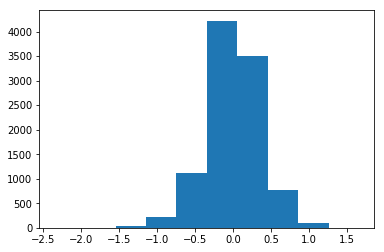

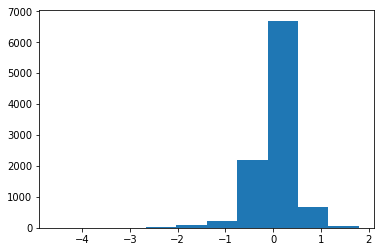

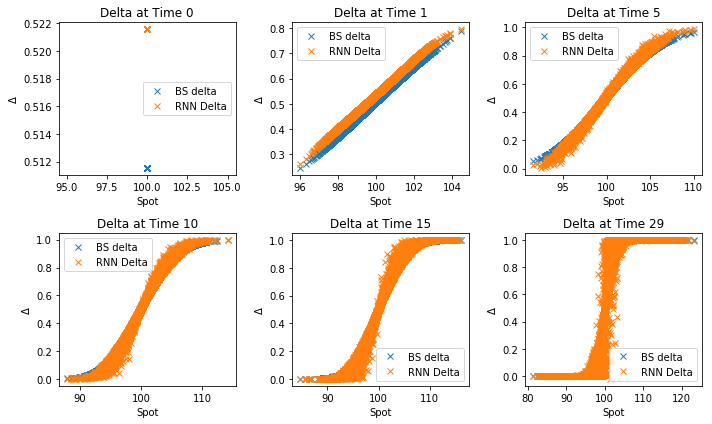

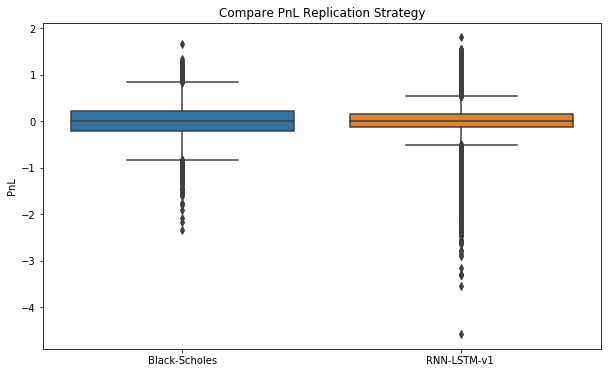

In [16]:
_,_,_,portfolio_pnl_bs, deltas_bs = black_scholes_hedge_strategy(S_0,K, r, vol, T, paths_test_1, alpha, True)
plt.figure()
_,_,_,portfolio_pnl_rnn, deltas_rnn = test_hedging_strategy(test1_results[2], paths_test_1, K, 2.302974467802428, alpha, True)
plot_deltas(paths_test_1, deltas_bs, deltas_rnn)
plt.savefig('rnn_050_deltas_1.png')
plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn)
plt.savefig('rnn_050_box_1.png')

## Out of sample test with different moneyness of the option

In [17]:
# Test set from the the same process but unseen
with tf.Session() as sess:
    model_1.restore(sess, './models/rnn_050/model.ckpt')
    test1a_results = model_1.predict(paths_test_1, np.ones(paths_test_1.shape[1])*(K-5), alpha, sess)

INFO:tensorflow:Restoring parameters from ./models/rnn_050/model.ckpt


BS price at t0: 5.577099409269991
Mean Hedging PnL: 0.0020790563222305818
CVaR Hedging PnL: 1.0789372205959642
BS price at t0: 5.57
Mean Hedging PnL: -0.0294307076288478
CVaR Hedging PnL: 3.5977042091035805


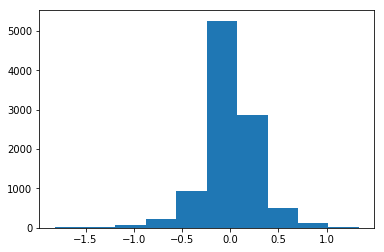

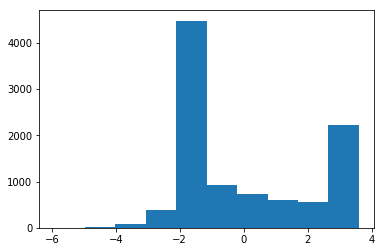

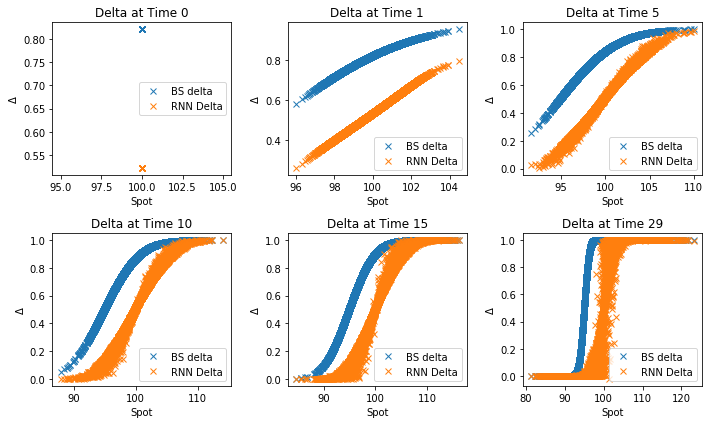

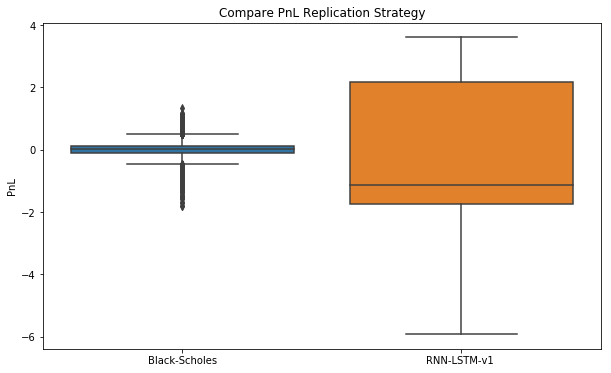

In [18]:
_,_,_,portfolio_pnl_bs, deltas_bs = black_scholes_hedge_strategy(S_0,K-5, r, vol, T, paths_test_1, alpha, True)
plt.figure()
_,_,_,portfolio_pnl_rnn, deltas_rnn = test_hedging_strategy(test1a_results[2], paths_test_1, K-5, 5.57, alpha, True)
plot_deltas(paths_test_1, deltas_bs, deltas_rnn)
plt.savefig('rnn_050_deltas_2.png')
plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn)
plt.savefig('rnn_050_box_2.png')

In [19]:
# Test set from the the same process but unseen
with tf.Session() as sess:
    model_1.restore(sess, './models/rnn_050/model.ckpt')
    test1b_results = model_1.predict(paths_test_1, np.ones(paths_test_1.shape[1])*(K+5), alpha, sess)
    




INFO:tensorflow:Restoring parameters from ./models/rnn_050/model.ckpt


BS price at t0: 0.65622183818396
Mean Hedging PnL: -0.004142995030550886
CVaR Hedging PnL: 1.212419072574511
BS price at t0: 0.65
Mean Hedging PnL: 0.010767869699117022
CVaR Hedging PnL: 3.270296785875704


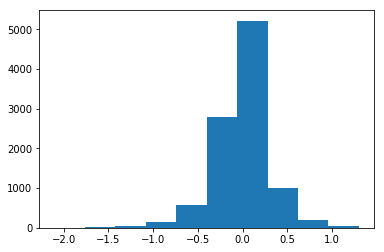

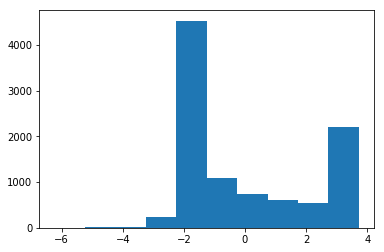

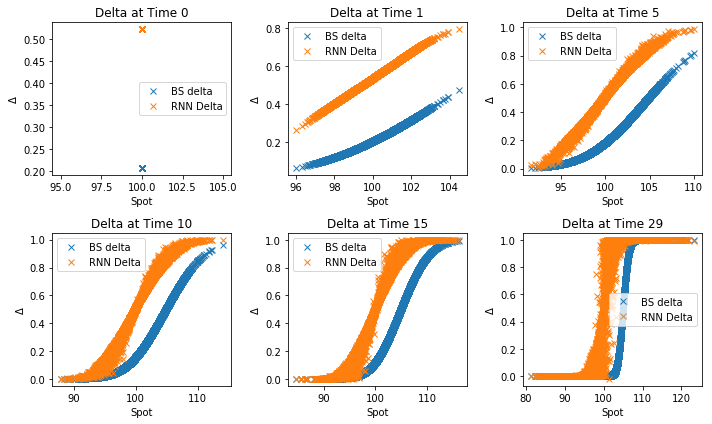

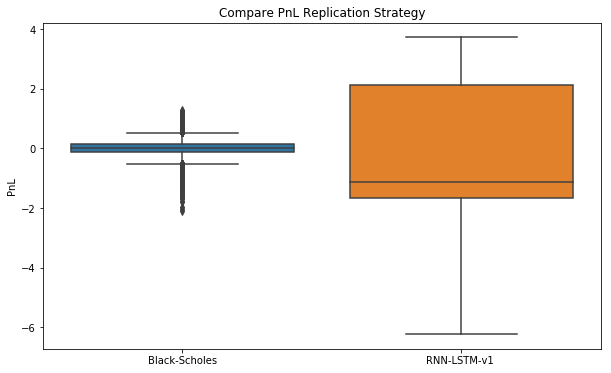

In [20]:
_,_,_,portfolio_pnl_bs, deltas_bs = black_scholes_hedge_strategy(S_0,K+5, r, vol, T, paths_test_1, alpha, True)
plt.figure()
_,_,_,portfolio_pnl_rnn, deltas_rnn = test_hedging_strategy(test1b_results[2], paths_test_1, K+5, 0.65, alpha, True)
plot_deltas(paths_test_1, deltas_bs, deltas_rnn)
plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn)

### Out of sample different drift

In [21]:
# Test set 2: Assume the drift of the underlying is 4% per month under the real world measure 
paths_test_2 = monte_carlo_paths(S_0, T, vol, 0.48-r, 21122017, 10000, timesteps)
# Test set from the the same process but unseen
with tf.Session() as sess:
    model_1.restore(sess, './models/rnn_050/model.ckpt')
    test2_results = model_1.predict(paths_test_2, np.ones(paths_test_2.shape[1])*K, alpha, sess)

INFO:tensorflow:Restoring parameters from ./models/rnn_050/model.ckpt


BS price at t0: 2.3029744678024286
Mean Hedging PnL: -0.017239029648273896
CVaR Hedging PnL: 1.2141220199385756
BS price at t0: 2.3
Mean Hedging PnL: -0.01064340560603923
CVaR Hedging PnL: 2.155336604239599


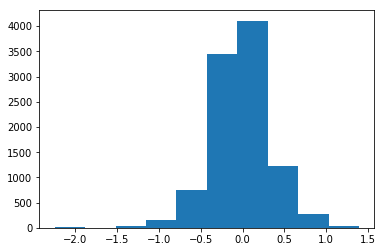

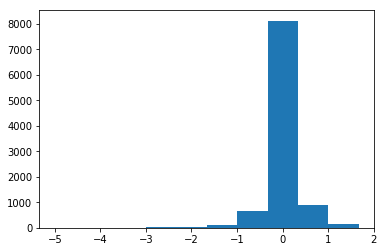

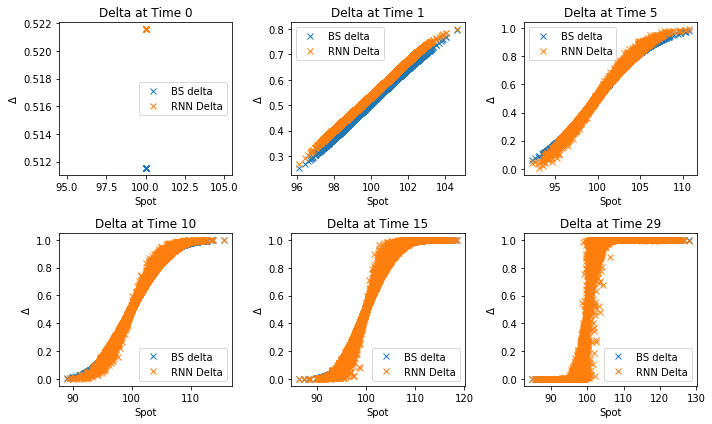

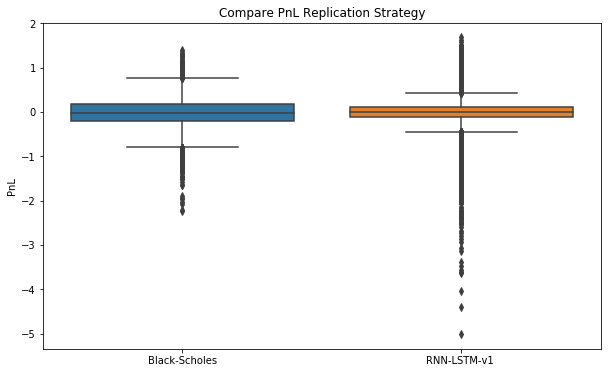

In [22]:
_,_,_,portfolio_pnl_bs, deltas_bs = black_scholes_hedge_strategy(S_0,K, r, vol, T, paths_test_2, alpha, True)
plt.figure()
_,_,_,portfolio_pnl_rnn, deltas_rnn = test_hedging_strategy(test2_results[2], paths_test_2, K, 2.30, alpha, True)
plot_deltas(paths_test_2, deltas_bs, deltas_rnn)
plt.savefig('rnn_050_deltas_3.png')
plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn)
plt.savefig('rnn_050_box_3.png')

### Out of sample and shifted volatility

In [23]:
# Test set 3: Assume the volatility is not constant and the realized volatility is 5% higher 
# than the implied (historical observed) one
paths_test_3 = monte_carlo_paths(S_0, T, vol+0.05, r, 21122017, 10000, timesteps)
# Test set from the the same process but unseen
with tf.Session() as sess:
    model_1.restore(sess, './models/rnn_050/model.ckpt')
    test3_results = model_1.predict(paths_test_3, np.ones(paths_test_3.shape[1])*K, alpha, sess)

INFO:tensorflow:Restoring parameters from ./models/rnn_050/model.ckpt


BS price at t0: 2.3029744678024286
Mean Hedging PnL: -0.5787493248269506
CVaR Hedging PnL: 2.558392282440757
BS price at t0: 2.3
Mean Hedging PnL: -0.5784306975519082
CVaR Hedging PnL: 4.8916941218788415


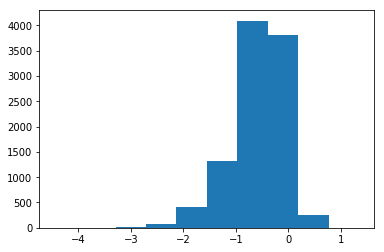

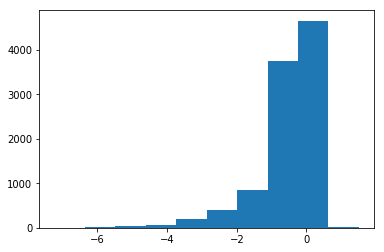

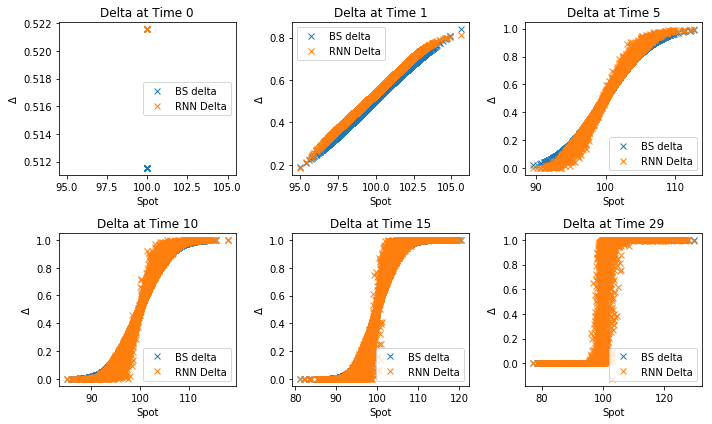

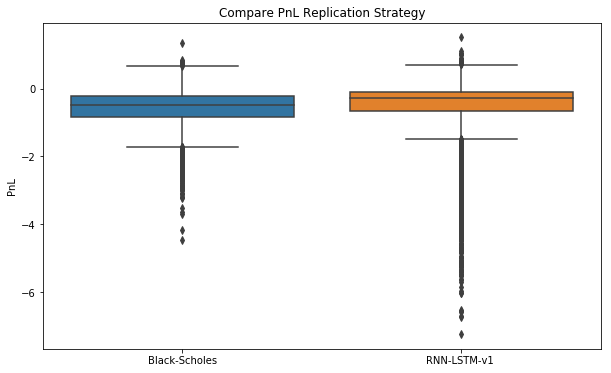

In [24]:
_,_,_,portfolio_pnl_bs, deltas_bs = black_scholes_hedge_strategy(S_0,K, r, vol, T, paths_test_3, alpha, True)
plt.figure()
_,_,_,portfolio_pnl_rnn, deltas_rnn = test_hedging_strategy(test3_results[2], paths_test_3, K, 2.30, alpha, True)
plot_deltas(paths_test_3, deltas_bs, deltas_rnn)
plt.savefig('rnn_050_deltas_4.png')
plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn)
plt.savefig('rnn_050_box_4.png')